In [ ]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 17.9 MB/s eta 0:00:00


In [ ]:
# math related packages
import scipy as sc
import qutip as qt
import numpy as np
import pandas as pd

# further packages
from time import time
from random import sample
import matplotlib.pyplot as plt
# ket states
qubit0 = qt.basis(2,0)
qubit1 = qt.basis(2,1)
# density matrices
qubit0mat = qubit0 * qubit0.dag() # it is also possible to use ket2dm(qubit0)
qubit1mat = qubit1 * qubit1.dag() # it is also possible to use ket2dm(qubit1)

def partialTraceKeep(obj, keep): # generalisation of ptrace(), partial trace via "to-keep" list
    # return partial trace:
    res = obj;
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

def partialTraceRem(obj, rem): # partial trace via "to-remove" list
    # prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    res = obj;
    # return partial trace:
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;
def swappedOp(obj, i, j):
    if i==j: return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)
def tensoredId(N):
    #Make Identity matrix
    res = qt.qeye(2**N)
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def tensoredQubit0(N):
    #Make Qubit matrix
    res = qt.fock(2**N).proj() #for some reason ran faster than fock_dm(2**N) in tests
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def unitariesCopy(unitaries): # deep copyof a list of unitaries
    newUnitaries = []
    for layer in unitaries:
        newLayer = []
        for unitary in layer:
            newLayer.append(unitary.copy())
        newUnitaries.append(newLayer)
    return newUnitaries


########Change this function for chaning gaussian######



def randomTrainingData(unitary, N): # generating training data based on a unitary
    numQubits = len(unitary.dims[0])
    trainingData=[]
    #Create training data pairs
    for i in range(N):
        t =randomMixedQubitDensityMatrix(numQubits)
        ut = unitary*t*unitary.dag()
        trainingData.append([t,ut])
    #Return
    return trainingData #####change should be here


def randomNetwork(qnnArch, numTrainingPairs):
    assert qnnArch[0]==qnnArch[-1], "Not a valid QNN-Architecture."

    #Create the targeted network unitary and corresponding training data
    networkUnitary = randomQubitUnitary(qnnArch[-1])
    networkTrainingData = randomTrainingData(networkUnitary, numTrainingPairs)

    #Create the initial random perceptron unitaries for the network
    networkUnitaries = [[]]
    for l in range(1, len(qnnArch)):
        numInputQubits = qnnArch[l-1]
        numOutputQubits = qnnArch[l]

        networkUnitaries.append([])
        for j in range(numOutputQubits):
            unitary = randomQubitUnitary(numInputQubits+1)
            if numOutputQubits-1 != 0:
                unitary = qt.tensor(randomQubitUnitary(numInputQubits+1), tensoredId(numOutputQubits-1))
                unitary = swappedOp(unitary, numInputQubits, numInputQubits + j)
            networkUnitaries[l].append(unitary)

    #Return
    return (qnnArch, networkUnitaries, networkTrainingData, networkUnitary)

######Fidelity cost function######
def costFunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        costSum += qt.fidelity(trainingData[i][1],outputStates[i])
    #print(np.real(costSum)/len(trainingData))
    return np.real(costSum)/len(trainingData)


##entropy cost function ##
def entropy_costfunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        # Target state (pure state vector |psi>)
        target_state = trainingData[i][1]

        # Predicted state (density matrix)
        predicted_output = outputStates[i]

        # # Eigen decomposition of predicted_output to compute log(sigma)
        # eig_vals, eig_vecs = predicted_output.eigenstates()

        # # Construct log(sigma)
        # log_rho = sum(val * vec * vec.dag() * np.log(val) if val > 0 else 0
        #                 for val, vec in zip(eig_vals, eig_vecs))

        # # Relative entropy: - <psi| log(sigma) |psi>
        # #relative_entropy = - (target_state.dag() * log_rho * target_state)
        # relative_entropy=-((target_state*log_rho)+log_rho*target_state).tr()

        # Add only the real part to costSum
        costSum += qt.entropy_relative(target_state, predicted_output)
    #print(f"costSum:{costSum}")
    costSum=costSum/len(trainingData)
    return costSum



    ###feedforward####
def makeLayerChannel(qnnArch, unitaries, l, inputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(inputState, tensoredQubit0(numOutputQubits))

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out input state
    return partialTraceRem(layerUni * state * layerUni.dag(), list(range(numInputQubits)))
def makeAdjointLayerChannel(qnnArch, unitaries, l, outputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Prepare needed states
    inputId = tensoredId(numInputQubits)
    state1 = qt.tensor(inputId, tensoredQubit0(numOutputQubits))
    state2 = qt.tensor(inputId, outputState)

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out output state
    return partialTraceKeep(state1 * layerUni.dag() * state2 * layerUni, list(range(numInputQubits)) )
def feedforward(qnnArch, unitaries, trainingData):
    storedStates = []
    for x in range(len(trainingData)):
        currentState = trainingData[x][0]
        layerwiseList = [currentState]
        for l in range(1, len(qnnArch)):
            currentState = makeLayerChannel(qnnArch, unitaries, l, currentState)
            layerwiseList.append(currentState)
        storedStates.append(layerwiseList)
    return storedStates


    ##### update matrix according to paper ####
def makeUpdateMatrix(qnnArch, unitaries, trainingData, storedStates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]

    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x)
        mat = qt.commutator(firstPart, secondPart)

        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)

        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))

    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni

    #Multiply
    return productUni * state * productUni.dag()


def updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Calculate sigma state
    state = trainingData[x][1]  ####### density matrix directly
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)

    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni

    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    res = makeUpdateMatrix(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j)
    if numOutputQubits-1 != 0:
        res = qt.tensor(res, tensoredId(numOutputQubits-1))
    return swappedOp(res, numInputQubits, numInputQubits + j)



In [ ]:
def randomQubitUnitary(numQubits): # alternatively, use functions rand_unitary and rand_unitary_haar
    dim = 2**numQubits
    #Make unitary matrix
    res = np.random.normal(size=(dim,dim)) + 1j * np.random.normal(size=(dim,dim))
    res = sc.linalg.orth(res)
    res = qt.Qobj(res)
    #Make dims list
    dims = [2 for i in range(numQubits)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res
def randomQubitState(numQubits): # alternatively, use functions rand_ket and rand_ket_haar
    dim = 2**numQubits
    #Make normalized state
    res = np.random.uniform(low=0, high=1,size=(dim,1)) + 1j * np.random.uniform(low=0, high=1,size=(dim,1))
    res = (1/sc.linalg.norm(res)) * res
    res = qt.Qobj(res)
    #Make dims list
    dims1 = [2 for i in range(numQubits)]
    dims2 = [1 for i in range(numQubits)]
    dims = [dims1, dims2]
    res.dims = dims
    #Return
    return res
def randomMixedQubitDensityMatrix(numQubits, numStates=3):
    """
    Generate a random mixed density matrix for a given number of qubits.

    Parameters:
    - numQubits: int, the number of qubits.
    - numStates: int, the number of pure states to mix (default: 3).

    Returns:
    - density_matrix: qutip.Qobj, a mixed density matrix.
    """
    dim = 2**numQubits
    density_matrix = qt.Qobj(np.zeros((dim, dim), dtype=complex))

    # Generate a set of random pure states
    for _ in range(numStates):
        state = np.random.uniform(low=0, high=1, size=(dim, 1)) + 1j * np.random.uniform(low=0, high=1, size=(dim, 1))
        state = (1 / np.linalg.norm(state)) * state  # Normalize the state
        state = qt.Qobj(state)

        # Compute the density matrix for this pure state
        pure_density = state * state.dag()

        # Add the weighted pure state to the mixed density matrix
        weight = np.random.uniform(0, 1)  # Random weight
        density_matrix += weight * pure_density

    # Normalize the mixed density matrix
    density_matrix = density_matrix / density_matrix.tr()

    # Set dimensions
    dims1 = [2 for _ in range(numQubits)]
    density_matrix.dims = [dims1, dims1]
    return density_matrix


In [ ]:
def qnnTraining(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):

    ### FEEDFORWARD
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)],[entropy_costfunction(trainingData, outputStates)]]

    #Optional
    runtime = time()

    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))

        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)

        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]

            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored(qnnArch,currentUnitaries,trainingData,storedStates,lda,ep,l,j)* currentUnitaries[l][j])

        ### FEEDFORWARD
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))
        plotlist[2].append(entropy_costfunction(trainingData, outputStates))

    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")

    #Return1
    return [plotlist, currentUnitaries]

Trained 500 rounds for a [2, 3, 2] network and 10 training pairs in 73.62 seconds
Exceeds cost of 0.95 at training step 18


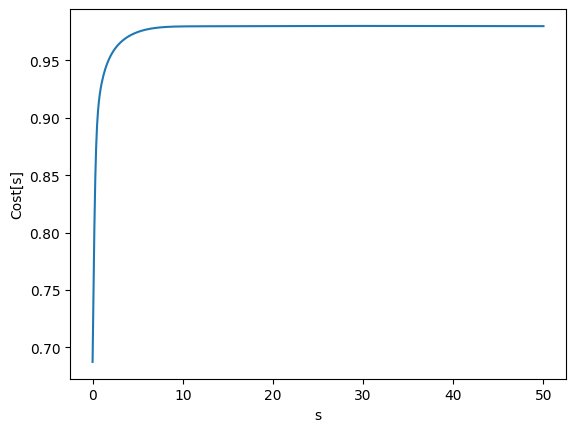

In [ ]:
network121 = randomNetwork([2,3,2], 10)
plotlist121 = qnnTraining(network121[0], network121[1], network121[2], 1, 0.1, 500)[0]

for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step "+str(i))
        break

plt.plot(plotlist121[0], plotlist121[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [ ]:
### our model ###
def makeUpdateMatrix_en(qnnArch, unitaries, trainingData, storedStates,outputstates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]

    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart_en(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart_en(qnnArch, unitaries, trainingData, outputstates, l, j, x)
        mat = qt.commutator(firstPart, secondPart)

        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)

        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart_en(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))

    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni

    #Multiply
    return productUni * state * productUni.dag()



def updateMatrixSecondPart_en(qnnArch, unitaries, trainingData,outputstates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Calculate sigma state
    state = trainingData[x][1]*outputstates[x].inv()
    #print(f"trainingData:{trainingData[x][1]}")


    state=(state+state.dag())/2
    #state=state/state.tr()

    #print(f"State_before{state}")
    #breakpoint()

    state=wEVD(state)


    #print(f"stateEVD:{state} done")
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)

    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni

    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored_en(qnnArch, unitaries, lda, ep, trainingData, storedStates,outputstates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    res = makeUpdateMatrix_en(qnnArch, unitaries, lda, ep, trainingData, storedStates,outputstates, l, j)
    if numOutputQubits-1 != 0:
        res = qt.tensor(res, tensoredId(numOutputQubits-1))
    return swappedOp(res, numInputQubits, numInputQubits + j)

In [ ]:
from qutip import Qobj
import numpy as np

def wEVD(sta):
    # Extract the 2D matrix (data) from the Qobj
    matrix = sta.full()

    # Perform eigenvalue decomposition on the matrix (numpy-based)
    ev, evc = np.linalg.eigh(matrix)  # eigh is used for Hermitian matrices

    # Separate negative and positive eigenvalues
    negative_sum = sum(ev[ev < 0])

    # Set negative eigenvalues to zero
    ev[ev < 0] = 0

    # Sort positive eigenvalues in ascending order
    ev_pos_sorted_indices = sorted(range(len(ev)), key=lambda i: ev[i])

    # Subtract the negative sum from the smallest positive eigenvalues
    for idx in ev_pos_sorted_indices:
        if ev[idx] > 0 and negative_sum < 0:
            subtract_amount = min(ev[idx], -negative_sum)
            ev[idx] -= subtract_amount
            negative_sum += subtract_amount  # Decrease the negative sum
            if negative_sum == 0:
                break
    ev/=np.sum(ev)
    # Reconstruct the new matrix
    evc_matrix = np.array(evc)  # Convert eigenvectors into a numpy array
    diag_matrix = np.diag(ev)   # Create diagonal matrix of modified eigenvalues
    new_matrix = evc_matrix @ diag_matrix @ evc_matrix.T.conj()  # Reconstruct new matrix

    # Create a new Qobj with the modified data but same properties as the original
    new_sta = Qobj(new_matrix, dims=sta.dims)

    # Ensure the new state has the same Hermiticity property
    new_sta.isherm = sta.isherm

    # Print the properties to verify

    return new_sta


In [ ]:
def qnnTraining_en(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):

    ### FEEDFORWARD
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)],[entropy_costfunction(trainingData, outputStates)]]
    #Optional
    runtime = time()

    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))

        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)

        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]

            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored_en(qnnArch,currentUnitaries,trainingData,storedStates,outputStates,lda,ep,l,j)* currentUnitaries[l][j])
                #print(f"stored{storedStates}")

        ### FEEDFORWARD
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))
        ######Entropy_costfuntion####
        plotlist[2].append(entropy_costfunction(trainingData, outputStates))
        #print(f"outputlo:{outputStates} done")

    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for relative entropy based method and  a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")

    #Return
    return [plotlist, currentUnitaries]

In [ ]:
# network121 = randomNetwork([1,2,1], 10)
# plotlist121_en = qnnTraining_en(network121[0], network121[1], network121[2], 1, 0.08, 200)[0]
# plotlist121=qnnTraining(network121[0], network121[1], network121[2], 1, 0.08, 200)[0]
# for i in range(len(plotlist121[1])):
#     if plotlist121[1][i] >= 0.95:
#         print("Exceeds cost of 0.95 at training step "+str(i))
#         break

# plt.plot(plotlist121[0], plotlist121[1],label="Existing Method")
# plt.plot(plotlist121_en[0], plotlist121_en[1],label="Proposed Method")
# plt.legend()
# plt.xlabel("s")
# plt.ylabel("Fidelity Cost[s]")
# plt.show()
# plt.figure()
# plt.plot(plotlist121[0], plotlist121[2],label="Existing Method")
# plt.plot(plotlist121_en[0], plotlist121_en[2],label="Proposed Method")
# plt.xlabel("s")
# plt.ylabel("Entropy Cost[s]")
# plt.legend()
# print(f"Original method Fidelity Cost end:{plotlist121[1][len(plotlist121[1])-1]}")
# print(f"Proposed method Fidelity Cost end:{plotlist121_en[1][len(plotlist121[1])-1]}")
# print(f"Original method Entropy Cost end:{plotlist121[2][len(plotlist121[2])-1]}")
# print(f"Proposed method Entropy Cost end:{plotlist121_en[2][len(plotlist121[2])-1]}")

Trained 250 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 50 training pairs in 510.51 seconds
Trained 250 rounds for a [2, 3, 3, 2] network and 50 training pairs in 439.11 seconds
Exceeds cost of 0.95 at training step 245


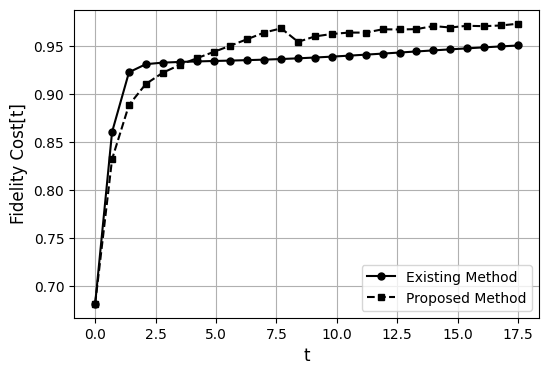

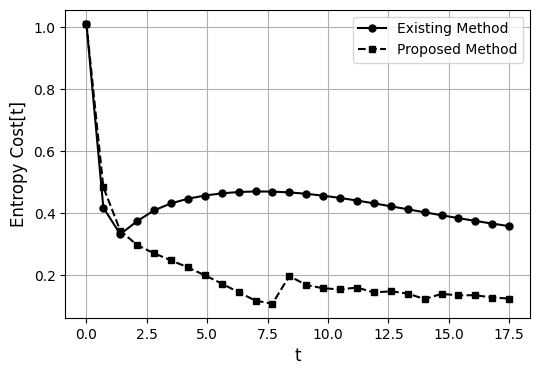

Two pure state is creating the mixed state results
Original method Fidelity Cost end: 0.9505090708822419
Proposed method Fidelity Cost end: 0.9731437291516769
Original method Entropy Cost end: 0.35867951268936393
Proposed method Entropy Cost end: 0.12559486659399513


In [ ]:
import matplotlib.pyplot as plt

# Assuming randomNetwork, qnnTraining_en, and qnnTraining are pre-defined functions
network121 = randomNetwork([2,3,3,2], 50)
plotlist121_en = qnnTraining_en(network121[0], network121[1], network121[2], 1, 0.07, 250)[0]
plotlist121 = qnnTraining(network121[0], network121[1], network121[2], 1, 0.07, 250)[0]

# Check for fidelity cost exceeding 0.95
for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step " + str(i))
        break

# Adjust plot intervals for 's' values (plot every 10th point)
interval = 10
s_values_existing = plotlist121[0][::interval]
fidelity_cost_existing = plotlist121[1][::interval]
entropy_cost_existing = plotlist121[2][::interval]

s_values_proposed = plotlist121_en[0][::interval]
fidelity_cost_proposed = plotlist121_en[1][::interval]
entropy_cost_proposed = plotlist121_en[2][::interval]

# Plot Fidelity Cost
fidelity_data = {
    "s_values_existing": s_values_existing,
    "fidelity_cost_existing": fidelity_cost_existing,
    "s_values_proposed": s_values_existing,  # Assuming the same x-values for proposed
    "fidelity_cost_proposed": fidelity_cost_proposed,
}
entropy_data = {
    "s_values_existing": s_values_existing,
    "entropy_cost_existing": entropy_cost_existing,
    "s_values_proposed": s_values_existing,  # Assuming the same x-values for proposed
    "entropy_cost_proposed": entropy_cost_proposed,
}

# Save to CSV with the naming convention
fidelity_df = pd.DataFrame(fidelity_data)
fidelity_df.to_csv("Fidelity_Cost_HighRes_BW_2_3_3_2.csv", index=False)

entropy_df = pd.DataFrame(entropy_data)
entropy_df.to_csv("Entropy_Cost_HighRes_BW_2_3_3_2.csv", index=False)

# Plot Fidelity Cost
plt.figure(figsize=(6, 4))  # Adjust the size to fit in two-column format
plt.plot(s_values_existing, fidelity_cost_existing, 'o-', color='black', label="Existing Method", markersize=5)
plt.plot(s_values_existing, fidelity_cost_proposed, 's--', color='black', label="Proposed Method", markersize=5)
plt.legend(fontsize=10)  # Decrease font size for IEEE two-column format
plt.xlabel("t", fontsize=12)  # Decrease xlabel font size
plt.ylabel("Fidelity Cost[t]", fontsize=12)  # Decrease ylabel font size
plt.xticks(fontsize=10)  # Decrease axis tick font size
plt.yticks(fontsize=10)  # Decrease axis tick font size
plt.grid(True)  # Enable grid
plt.savefig("Fidelity_Cost_HighRes_BW_2_3_3_2.png", dpi=300)  # Save in high resolution
plt.show()

# Plot Entropy Cost
plt.figure(figsize=(6, 4))  # Adjust the size to fit in two-column format
plt.plot(s_values_existing, entropy_cost_existing, 'o-', color='black', label="Existing Method", markersize=5)
plt.plot(s_values_existing, entropy_cost_proposed, 's--', color='black', label="Proposed Method", markersize=5)
plt.legend(fontsize=10)  # Decrease font size for IEEE two-column format
plt.xlabel("t", fontsize=12)  # Decrease xlabel font size
plt.ylabel("Entropy Cost[t]", fontsize=12)  # Decrease ylabel font size
plt.xticks(fontsize=10)  # Decrease axis tick font size
plt.yticks(fontsize=10)  # Decrease axis tick font size
plt.grid(True)  # Enable grid
plt.savefig("Entropy_Cost_HighRes_BW_2_3_3_2.png", dpi=300)  # Save in high resolution
plt.show()
# Print final results
print("Two pure state is creating the mixed state results")
print(f"Original method Fidelity Cost end: {plotlist121[1][-1]}")
print(f"Proposed method Fidelity Cost end: {plotlist121_en[1][-1]}")
print(f"Original method Entropy Cost end: {plotlist121[2][-1]}")
print(f"Proposed method Entropy Cost end: {plotlist121_en[2][-1]}")


Trained 250 rounds for relative entropy based method and  a [3, 4, 3] network and 50 training pairs in 1223.34 seconds
Trained 250 rounds for a [3, 4, 3] network and 50 training pairs in 1213.15 seconds


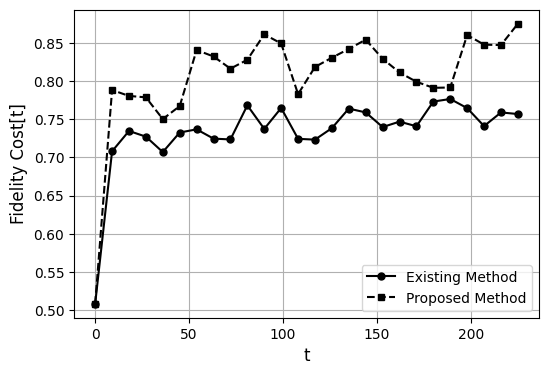

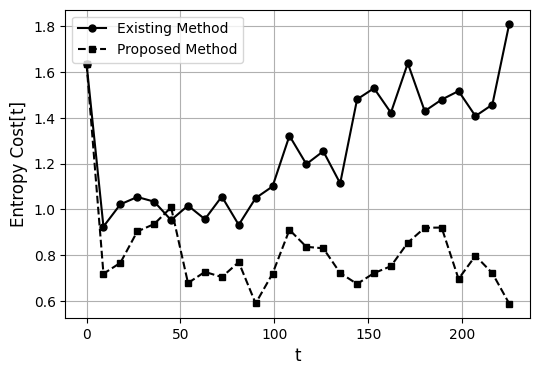

Original method Fidelity Cost end: 0.7569481543053028
Proposed method Fidelity Cost end: 0.8753022826683714
Original method Entropy Cost end: 1.8111490794110834
Proposed method Entropy Cost end: 0.588153698725795


In [ ]:
import matplotlib.pyplot as plt

# Assuming randomNetwork, qnnTraining_en, and qnnTraining are pre-defined functions
network121 = randomNetwork([3, 4,3], 50)
plotlist121_en = qnnTraining_en(network121[0], network121[1], network121[2], 1.2, 0.9, 250)[0]
plotlist121 = qnnTraining(network121[0], network121[1], network121[2], 1.2, 0.9, 250)[0]

# Check for fidelity cost exceeding 0.95
for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step " + str(i))
        break

# Adjust plot intervals for 's' values (plot every 10th point)
interval = 10
s_values_existing = plotlist121[0][::interval]
fidelity_cost_existing = plotlist121[1][::interval]
entropy_cost_existing = plotlist121[2][::interval]

s_values_proposed = plotlist121_en[0][::interval]
fidelity_cost_proposed = plotlist121_en[1][::interval]
entropy_cost_proposed = plotlist121_en[2][::interval]

# Plot Fidelity Cost
fidelity_df = pd.DataFrame(fidelity_data)
fidelity_df.to_csv("Fidelity_Cost_HighRes_BW_3_4_3.csv", index=False)

entropy_df = pd.DataFrame(entropy_data)
entropy_df.to_csv("Entropy_Cost_HighRes_BW_3_4_3.csv", index=False)

# Plot Fidelity Cost
plt.figure(figsize=(6, 4))  # Adjust the size to fit in two-column format
plt.plot(s_values_existing, fidelity_cost_existing, 'o-', color='black', label="Existing Method", markersize=5)
plt.plot(s_values_existing, fidelity_cost_proposed, 's--', color='black', label="Proposed Method", markersize=5)
plt.legend(fontsize=10)  # Decrease font size for IEEE two-column format
plt.xlabel("t", fontsize=12)  # Decrease xlabel font size
plt.ylabel("Fidelity Cost[t]", fontsize=12)  # Decrease ylabel font size
plt.xticks(fontsize=10)  # Decrease axis tick font size
plt.yticks(fontsize=10)  # Decrease axis tick font size
plt.grid(True)  # Enable grid
plt.savefig("Fidelity_Cost_HighRes_BW_3_4_3.png", dpi=300)  # Save in high resolution
plt.show()

# Plot Entropy Cost
plt.figure(figsize=(6, 4))  # Adjust the size to fit in two-column format
plt.plot(s_values_existing, entropy_cost_existing, 'o-', color='black', label="Existing Method", markersize=5)
plt.plot(s_values_existing, entropy_cost_proposed, 's--', color='black', label="Proposed Method", markersize=5)
plt.legend(fontsize=10)  # Decrease font size for IEEE two-column format
plt.xlabel("t", fontsize=12)  # Decrease xlabel font size
plt.ylabel("Entropy Cost[t]", fontsize=12)  # Decrease ylabel font size
plt.xticks(fontsize=10)  # Decrease axis tick font size
plt.yticks(fontsize=10)  # Decrease axis tick font size
plt.grid(True)  # Enable grid
plt.savefig("Entropy_Cost_HighRes_BW_3_4_3.png", dpi=300)  # Save in high resolution
plt.show()
# Print final results
print(f"Original method Fidelity Cost end: {plotlist121[1][-1]}")
print(f"Proposed method Fidelity Cost end: {plotlist121_en[1][-1]}")
print(f"Original method Entropy Cost end: {plotlist121[2][-1]}")
print(f"Proposed method Entropy Cost end: {plotlist121_en[2][-1]}")


Trained 100 rounds for relative entropy based method and  a [1, 3, 1] network and 50 training pairs in 54.27 seconds
Trained 100 rounds for a [1, 3, 1] network and 50 training pairs in 45.34 seconds
Exceeds cost of 0.95 at training step 5


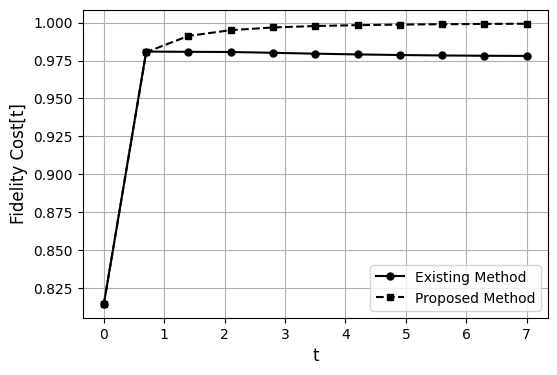

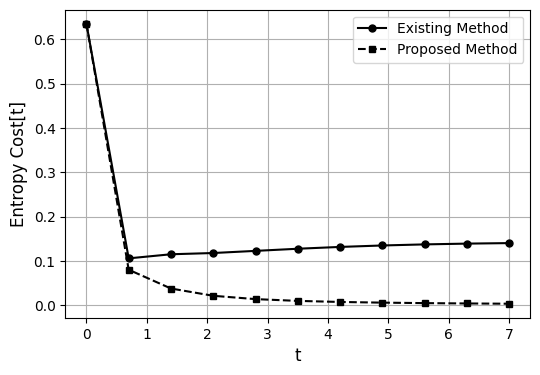

Two pure state is creating the mixed state results
Original method Fidelity Cost end: 0.9780255186168327
Proposed method Fidelity Cost end: 0.9992545109916406
Original method Entropy Cost end: 0.14006345688092367
Proposed method Entropy Cost end: 0.0032103327852410226


In [ ]:
import matplotlib.pyplot as plt

# Assuming randomNetwork, qnnTraining_en, and qnnTraining are pre-defined functions
network121 = randomNetwork([1, 3, 1], 50)
plotlist121_en = qnnTraining_en(network121[0], network121[1], network121[2], 1, 0.07, 100)[0]
plotlist121 = qnnTraining(network121[0], network121[1], network121[2], 1, 0.07, 100)[0]

# Check for fidelity cost exceeding 0.95
for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step " + str(i))
        break

# Adjust plot intervals for 's' values (plot every 10th point)
interval = 10
s_values_existing = plotlist121[0][::interval]
fidelity_cost_existing = plotlist121[1][::interval]
entropy_cost_existing = plotlist121[2][::interval]

s_values_proposed = plotlist121_en[0][::interval]
fidelity_cost_proposed = plotlist121_en[1][::interval]
entropy_cost_proposed = plotlist121_en[2][::interval]

fidelity_data = {
    "s_values_existing": s_values_existing,
    "fidelity_cost_existing": fidelity_cost_existing,
    "s_values_proposed": s_values_existing,  # Assuming the same x-values for proposed
    "fidelity_cost_proposed": fidelity_cost_proposed,
}
entropy_data = {
    "s_values_existing": s_values_existing,
    "entropy_cost_existing": entropy_cost_existing,
    "s_values_proposed": s_values_existing,  # Assuming the same x-values for proposed
    "entropy_cost_proposed": entropy_cost_proposed,
}

# Save to CSV with the naming convention 1-3-1
fidelity_df = pd.DataFrame(fidelity_data)
fidelity_df.to_csv("Fidelity_Cost_HighRes_BW_1_3_1.csv", index=False)

entropy_df = pd.DataFrame(entropy_data)
entropy_df.to_csv("Entropy_Cost_HighRes_BW_1_3_1.csv", index=False)

# Plot Fidelity Cost
plt.figure(figsize=(6, 4))  # Adjust the size to fit in two-column format
plt.plot(s_values_existing, fidelity_cost_existing, 'o-', color='black', label="Existing Method", markersize=5)
plt.plot(s_values_existing, fidelity_cost_proposed, 's--', color='black', label="Proposed Method", markersize=5)
plt.legend(fontsize=10)  # Decrease font size for IEEE two-column format
plt.xlabel("t", fontsize=12)  # Decrease xlabel font size
plt.ylabel("Fidelity Cost[t]", fontsize=12)  # Decrease ylabel font size
plt.xticks(fontsize=10)  # Decrease axis tick font size
plt.yticks(fontsize=10)  # Decrease axis tick font size
plt.grid(True)  # Enable grid
plt.savefig("Fidelity_Cost_HighRes_BW_1_3_1.png", dpi=300)  # Save in high resolution
plt.show()

# Plot Entropy Cost
plt.figure(figsize=(6, 4))  # Adjust the size to fit in two-column format
plt.plot(s_values_existing, entropy_cost_existing, 'o-', color='black', label="Existing Method", markersize=5)
plt.plot(s_values_existing, entropy_cost_proposed, 's--', color='black', label="Proposed Method", markersize=5)
plt.legend(fontsize=10)  # Decrease font size for IEEE two-column format
plt.xlabel("t", fontsize=12)  # Decrease xlabel font size
plt.ylabel("Entropy Cost[t]", fontsize=12)  # Decrease ylabel font size
plt.xticks(fontsize=10)  # Decrease axis tick font size
plt.yticks(fontsize=10)  # Decrease axis tick font size
plt.grid(True)  # Enable grid
plt.savefig("Entropy_Cost_HighRes_BW_1_3_1.png", dpi=300)  # Save in high resolution
plt.show()
# Print final results
print("Two pure state is creating the mixed state results")
print(f"Original method Fidelity Cost end: {plotlist121[1][-1]}")
print(f"Proposed method Fidelity Cost end: {plotlist121_en[1][-1]}")
print(f"Original method Entropy Cost end: {plotlist121[2][-1]}")
print(f"Proposed method Entropy Cost end: {plotlist121_en[2][-1]}")


Training iteration 1/10
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 19.83 seconds
Training iteration 2/10
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 15.17 seconds
Training iteration 3/10
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 14.71 seconds
Training iteration 4/10
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 15.19 seconds
Training iteration 5/10
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 15.17 seconds
Training iteration 6/10
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 15.43 seconds
Training iteration 7/10
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 15.27 seconds

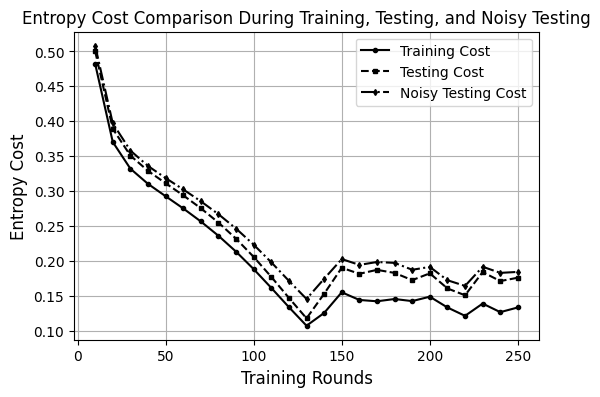


Final Results
Training Entropy Cost after 100 rounds: 0.13310068024835411
Testing Entropy Cost after 100 rounds: 0.1757203686712523
Noisy Testing Entropy Cost after 100 rounds: 0.1840255317556297


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import qutip as qt

# Generate random network data with flexible dimensions
data = randomNetwork([2, 3,3, 2], 50)  # Generate 50 data samples

# Split data into training and testing
training_data, testing_data = train_test_split(data[2], test_size=10 / 50, random_state=42)

# Function to add decoherence noise (works for any input dimension)
def add_decoherence_noise(data, noise_level):
    noisy_data = []
    for d in data:
        # Ensure the state is a Qobj
        state = qt.Qobj(d.full(), dims=d.dims) if isinstance(d, qt.Qobj) else qt.Qobj(d)

        # Create an identity matrix with the same structure as the state
        identity_matrix = qt.tensor([qt.qeye(d) for d in state.dims[0]])

        # Add decoherence noise by mixing the state with the identity matrix
        noisy_state = (1 - noise_level) * state + noise_level * identity_matrix / identity_matrix.tr()
        noisy_data.append(noisy_state)
    return noisy_data



# Add noise to the test data
noise_level = 0.1
noisy_testing_data = add_decoherence_noise([d[0] for d in testing_data], noise_level)
noisy_testing_data = [(noisy_state, testing_data[i][1]) for i, noisy_state in enumerate(noisy_testing_data)]

# Function to evaluate the QNN on provided data
def evaluate_qnn(qnnArch, trainedUnitaries, testingData):
    storedStates = feedforward(qnnArch, trainedUnitaries, testingData)
    outputStates = [states[-1] for states in storedStates]
    entropy_cost = entropy_costfunction(testingData, outputStates)
    return entropy_cost

# Initialize variables for performance metrics
entropy_cost_training_list = []
entropy_cost_testing_list = []
entropy_cost_noisy_testing_list = []

unitaries_proposed = data[1]  # Initialize with initial unitaries

for i in range(25):  # Train for a total of 100 rounds in steps of 10
    print(f"Training iteration {i + 1}/10")

    # Train for 10 rounds
    entropy_training_plot, unitaries_proposed = qnnTraining_en(data[0], unitaries_proposed, training_data, 1, 0.07, 10)

    # Evaluate entropy cost on training data
    entropy_training_cost = entropy_training_plot[2][-1]  # Last recorded entropy cost
    entropy_cost_training_list.append(entropy_training_cost)

    # Evaluate entropy cost on the test set
    entropy_testing_cost = evaluate_qnn(data[0], unitaries_proposed, testing_data)
    entropy_cost_testing_list.append(entropy_testing_cost)

    # Evaluate entropy cost on the noisy test set
    entropy_noisy_testing_cost = evaluate_qnn(data[0], unitaries_proposed, noisy_testing_data)
    entropy_cost_noisy_testing_list.append(entropy_noisy_testing_cost)
# Plot the entropy cost results
entropy_data = {
    "Training Entropy Cost": entropy_cost_training_list,
    "Testing Entropy Cost": entropy_cost_testing_list,
    "Noisy Testing Entropy Cost": entropy_cost_noisy_testing_list,
}

entropy_df = pd.DataFrame(entropy_data)
entropy_df.to_csv("Entropy_Cost_Comparison.csv", index=False)
x_axis_values = [x * 10 for x in range(1, len(entropy_cost_training_list) + 1)]
# Plot Entropy Cost Comparison
plt.figure(figsize=(6, 4))  # Adjust the size to fit in two-column format
plt.plot(x_axis_values, entropy_cost_training_list, 'o-', color='black', label="Training Cost", markersize=3)
plt.plot(x_axis_values, entropy_cost_testing_list, 's--', color='black', label="Testing Cost", markersize=3)
plt.plot(x_axis_values, entropy_cost_noisy_testing_list, 'd-.', color='black', label="Noisy Testing Cost", markersize=3)
plt.legend(fontsize=10)  # Decrease font size for IEEE two-column format
plt.xlabel("Training Rounds", fontsize=12)  # Decrease xlabel font size
plt.ylabel("Entropy Cost", fontsize=12)  # Decrease ylabel font size
plt.xticks(fontsize=10)  # Decrease axis tick font size
plt.yticks(fontsize=10)  # Decrease axis tick font size
plt.grid(True)  # Enable grid
plt.title("Entropy Cost Comparison During Training, Testing, and Noisy Testing", fontsize=12)  # Set title font size
plt.savefig("Entropy_Cost_Comparison.png", dpi=300)  # Save in high resolution
plt.show()

# Print final results
print("\nFinal Results")
print(f"Training Entropy Cost after 100 rounds: {entropy_cost_training_list[-1]}")
print(f"Testing Entropy Cost after 100 rounds: {entropy_cost_testing_list[-1]}")
print(f"Noisy Testing Entropy Cost after 100 rounds: {entropy_cost_noisy_testing_list[-1]}")


Training iteration 1/25
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.55 seconds
Training iteration 2/25
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.96 seconds
Training iteration 3/25
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.5 seconds
Training iteration 4/25
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.52 seconds
Training iteration 5/25
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.94 seconds
Training iteration 6/25
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.54 seconds
Training iteration 7/25
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.92 seconds


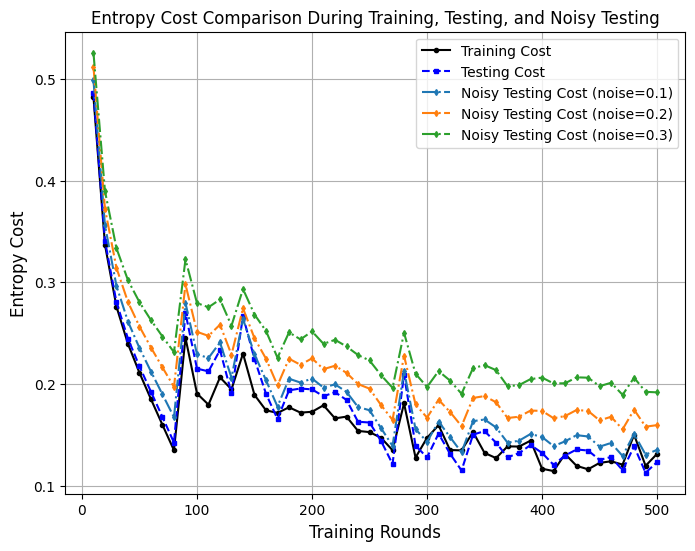


Final Results
Training Entropy Cost after 100 rounds: 0.13139150003070815
Testing Entropy Cost after 100 rounds: 0.12326443975815249
Noisy Testing Entropy Cost (noise=0.1) after 100 rounds: 0.13526989517562663
Noisy Testing Entropy Cost (noise=0.2) after 100 rounds: 0.15957981846715702
Noisy Testing Entropy Cost (noise=0.3) after 100 rounds: 0.19178329859925258


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import qutip as qt
import pandas as pd

# Generate random network data with flexible dimensions
data = randomNetwork([2, 3, 3, 2], 50)  # Generate 50 data samples

# Split data into training and testing
training_data, testing_data = train_test_split(data[2], test_size=10 / 50, random_state=42)

# Function to add decoherence noise (works for any input dimension)
def add_decoherence_noise(data, noise_level):
    noisy_data = []
    for d in data:
        # Ensure the state is a Qobj
        state = qt.Qobj(d.full(), dims=d.dims) if isinstance(d, qt.Qobj) else qt.Qobj(d)

        # Create an identity matrix with the same structure as the state
        identity_matrix = qt.tensor([qt.qeye(d) for d in state.dims[0]])

        # Add decoherence noise by mixing the state with the identity matrix
        noisy_state = (1 - noise_level) * state + noise_level * identity_matrix / identity_matrix.tr()
        noisy_data.append(noisy_state)
    return noisy_data

# Add noise to the test data for multiple noise levels
noise_levels = [0.1, 0.2, 0.3]  # Define three noise levels
noisy_testing_data_sets = {}
for level in noise_levels:
    noisy_data = add_decoherence_noise([d[0] for d in testing_data], level)
    noisy_testing_data_sets[level] = [(noisy_state, testing_data[i][1]) for i, noisy_state in enumerate(noisy_data)]

# Function to evaluate the QNN on provided data
def evaluate_qnn(qnnArch, trainedUnitaries, testingData):
    storedStates = feedforward(qnnArch, trainedUnitaries, testingData)
    outputStates = [states[-1] for states in storedStates]
    entropy_cost = entropy_costfunction(testingData, outputStates)
    return entropy_cost

# Initialize variables for performance metrics
entropy_cost_training_list = []
entropy_cost_testing_list = []
entropy_cost_noisy_testing_lists = {level: [] for level in noise_levels}

unitaries_proposed = data[1]  # Initialize with initial unitaries

for i in range(50):  # Train for a total of 100 rounds in steps of 10
    print(f"Training iteration {i + 1}/25")

    # Train for 1 round
    entropy_training_plot, unitaries_proposed = qnnTraining_en(data[0], unitaries_proposed, training_data, 1, 0.07, 10)

    # Evaluate entropy cost on training data
    entropy_training_cost = entropy_training_plot[2][-1]  # Last recorded entropy cost
    entropy_cost_training_list.append(entropy_training_cost)

    # Evaluate entropy cost on the test set
    entropy_testing_cost = evaluate_qnn(data[0], unitaries_proposed, testing_data)
    entropy_cost_testing_list.append(entropy_testing_cost)

    # Evaluate entropy cost on the noisy test sets for each noise level
    for level, noisy_testing_data in noisy_testing_data_sets.items():
        entropy_noisy_testing_cost = evaluate_qnn(data[0], unitaries_proposed, noisy_testing_data)
        entropy_cost_noisy_testing_lists[level].append(entropy_noisy_testing_cost)

# Plot the entropy cost results
entropy_data = {
    "Training Entropy Cost": entropy_cost_training_list,
    "Testing Entropy Cost": entropy_cost_testing_list,
}

# Add noisy testing data to the dictionary
for level, costs in entropy_cost_noisy_testing_lists.items():
    entropy_data[f"Noisy Testing Entropy Cost (noise={level})"] = costs

entropy_df = pd.DataFrame(entropy_data)
entropy_df.to_csv("Entropy_Cost_Comparison.csv", index=False)

x_axis_values = [x * 10 for x in range(1, len(entropy_cost_training_list) + 1)]

# Plot Entropy Cost Comparison
plt.figure(figsize=(8, 6))
plt.plot(x_axis_values, entropy_cost_training_list, 'o-', color='black', label="Training Cost", markersize=3)
plt.plot(x_axis_values, entropy_cost_testing_list, 's--', color='blue', label="Testing Cost", markersize=3)
for level, costs in entropy_cost_noisy_testing_lists.items():
    plt.plot(x_axis_values, costs, 'd-.', label=f"Noisy Testing Cost (noise={level})", markersize=3)

plt.legend(fontsize=10)
plt.xlabel("Training Rounds", fontsize=12)
plt.ylabel("Entropy Cost", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.title("Entropy Cost Comparison During Training, Testing, and Noisy Testing", fontsize=12)
plt.savefig("Entropy_Cost_Comparison.png", dpi=300)
plt.show()

# Print final results
print("\nFinal Results")
print(f"Training Entropy Cost after 100 rounds: {entropy_cost_training_list[-1]}")
print(f"Testing Entropy Cost after 100 rounds: {entropy_cost_testing_list[-1]}")
for level in noise_levels:
    print(f"Noisy Testing Entropy Cost (noise={level}) after 100 rounds: {entropy_cost_noisy_testing_lists[level][-1]}")


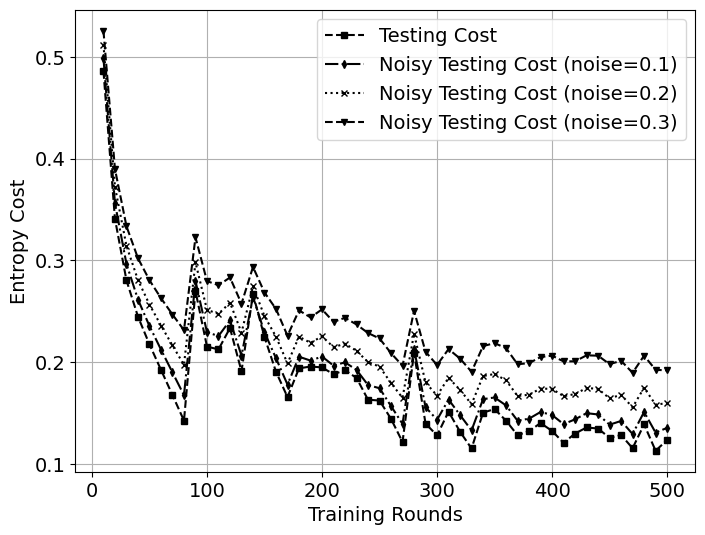

In [ ]:
plt.figure(figsize=(8, 6))
#plt.plot(x_axis_values, entropy_cost_training_list, 'o-', color='black', label="Training Cost", markersize=3)
plt.plot(x_axis_values, entropy_cost_testing_list, 's--', color='black', label="Testing Cost", markersize=4)
markers = ['d-.', 'x:', 'v--']  # Different markers and line styles for noise levels
for i, (level, costs) in enumerate(entropy_cost_noisy_testing_lists.items()):
    plt.plot(x_axis_values, costs, markers[i % len(markers)], color='black', label=f"Noisy Testing Cost (noise={level})", markersize=4)

plt.legend(fontsize=14)
plt.xlabel("Training Rounds", fontsize=14)
plt.ylabel("Entropy Cost", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.title("Entropy Cost Comparison During Training, Testing, and Noisy Testing", fontsize=12)
plt.savefig("Entropy_Cost_Comparison.png", dpi=300)
plt.show()


Training iteration 1/50
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 14.15 seconds
Trained 10 rounds for a [2, 3, 3, 2] network and 40 training pairs in 12.0 seconds
Training iteration 2/50
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 12.87 seconds
Trained 10 rounds for a [2, 3, 3, 2] network and 40 training pairs in 9.31 seconds
Training iteration 3/50
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.37 seconds
Trained 10 rounds for a [2, 3, 3, 2] network and 40 training pairs in 12.34 seconds
Training iteration 4/50
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.84 seconds
Trained 10 rounds for a [2, 3, 3, 2] network and 40 training pairs in 12.68 seconds
Training iteration 5/50
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2

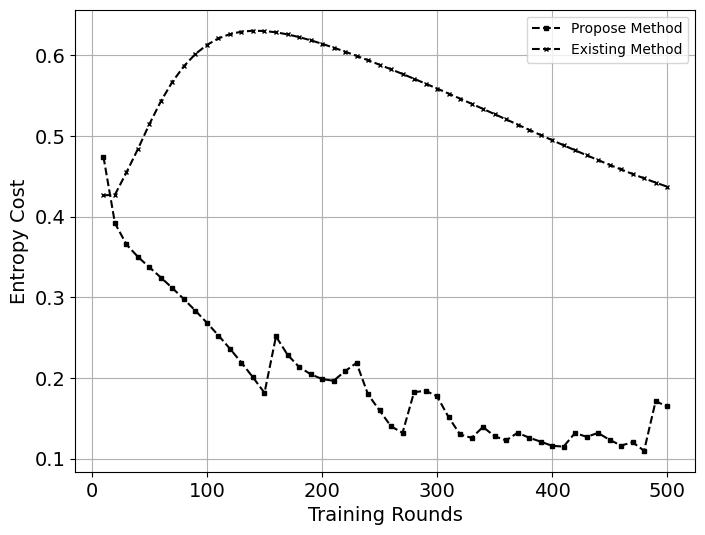

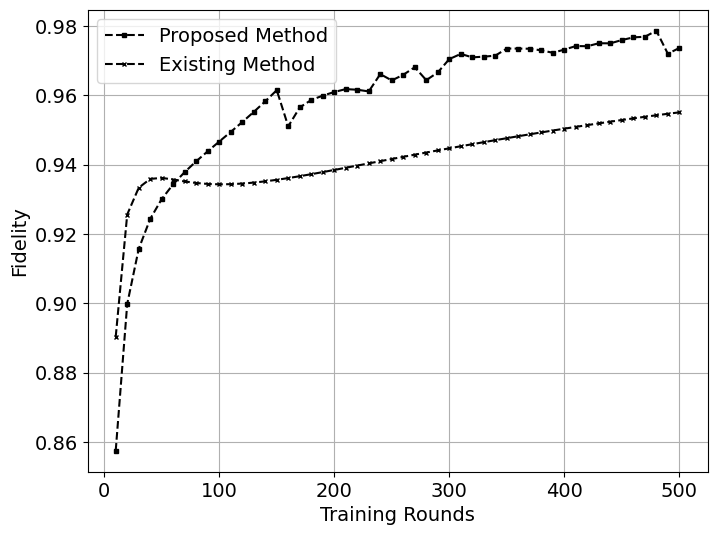


Final Results
Training Entropy Cost after 100 rounds (Method 1): 0.12564278897225306
Testing Entropy Cost after 100 rounds (Method 1): 0.16499153750045067
Training Entropy Cost after 100 rounds (Method 2): 0.3365321934855712
Testing Entropy Cost after 100 rounds (Method 2): 0.4371310506254765
Training Fidelity after 100 rounds (Method 1): 0.9736480183354225
Testing Fidelity after 100 rounds (Method 1): 0.9736480183354225
Training Fidelity after 100 rounds (Method 2): 0.9550661047957613
Testing Fidelity after 100 rounds (Method 2): 0.9550661047957613


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import qutip as qt

# Generate random network data with flexible dimensions
data = randomNetwork([2, 3, 3, 2], 50)  # Generate 50 data samples

# Split data into training and testing
training_data, testing_data = train_test_split(data[2], test_size=10 / 50, random_state=42)

# Function to evaluate the QNN on provided data
def evaluate_qnn(qnnArch, trainedUnitaries, testingData):
    storedStates = feedforward(qnnArch, trainedUnitaries, testingData)
    outputStates = [states[-1] for states in storedStates]
    entropy_cost = entropy_costfunction(testingData, outputStates)
    return entropy_cost

# Initialize variables for performance metrics
entropy_cost_training_list = []
entropy_cost_testing_list = []
fidelity_training_list = []
fidelity_testing_list = []
entropy_cost_training_fid_list = []
entropy_cost_testing_fid_list = []
fidelity_training_fid_list = []
fidelity_testing_fid_list = []

unitaries_proposed = data[1]  # Initialize with initial unitaries
unitaries_proposed_fid=data[1]
for i in range(50):  # Train for a total of 100 rounds in steps of 10
    print(f"Training iteration {i + 1}/50")

    # Train for 10 rounds using the first method
    entropy_training_plot, unitaries_proposed = qnnTraining_en(data[0], unitaries_proposed, training_data, 1, 0.07, 10)

    # Evaluate entropy cost on training data
    entropy_training_cost = entropy_training_plot[2][-1]  # Last recorded entropy cost
    entropy_cost_training_list.append(entropy_training_cost)

    # Evaluate fidelity on training data
    fidelity_training = entropy_training_plot[1][-1]  # Fidelity metric
    fidelity_training_list.append(fidelity_training)

    # Evaluate entropy cost on the test set
    entropy_testing_cost = evaluate_qnn(data[0], unitaries_proposed, testing_data)
    entropy_cost_testing_list.append(entropy_testing_cost)

    # Evaluate fidelity on the test set
    fidelity_testing = entropy_training_plot[1][-1]  # Fidelity metric (use appropriate testing metric if available)
    fidelity_testing_list.append(fidelity_testing)

    # Train for 10 rounds using the existing method
    entropy_training_plot_fid, unitaries_proposed_fid = qnnTraining(data[0], unitaries_proposed_fid, training_data, 1, 0.07, 10)

    # Evaluate entropy cost on training data for the existing method
    entropy_training_fid_cost = entropy_training_plot_fid[2][-1]  # Last recorded entropy cost
    entropy_cost_training_fid_list.append(entropy_training_fid_cost)

    # Evaluate fidelity on training data for the existing method
    fidelity_training_fid = entropy_training_plot_fid[1][-1]  # Fidelity metric
    fidelity_training_fid_list.append(fidelity_training_fid)

    # Evaluate entropy cost on the test set for the existing method
    entropy_testing_fid_cost = evaluate_qnn(data[0], unitaries_proposed_fid, testing_data)
    entropy_cost_testing_fid_list.append(entropy_testing_fid_cost)

    # Evaluate fidelity on the test set for the existing method
    fidelity_testing_fid = entropy_training_plot_fid[1][-1]  # Fidelity metric (use appropriate testing metric if available)
    fidelity_testing_fid_list.append(fidelity_testing_fid)

# Create and save the CSV files
entropy_data = {
    "Training Entropy Cost (Proposed)": entropy_cost_training_list,
    "Testing Entropy Cost (Proposed)": entropy_cost_testing_list,
    "Training Entropy Cost (existing)": entropy_cost_training_fid_list,
    "Testing Entropy Cost (existing)": entropy_cost_testing_fid_list,
}

fidelity_data = {
    "Training Fidelity (Proposed)": fidelity_training_list,
    "Testing Fidelity (Proposed)": fidelity_testing_list,
    "Training Fidelity (existing)": fidelity_training_fid_list,
    "Testing Fidelity (existing)": fidelity_testing_fid_list,
}

entropy_df = pd.DataFrame(entropy_data)
entropy_df.to_csv("Test_Entropy_Cost_Comparison.csv", index=False)

fidelity_df = pd.DataFrame(fidelity_data)
fidelity_df.to_csv("Test_Fidelity_Comparison.csv", index=False)

x_axis_values = [x * 10 for x in range(1, len(entropy_cost_training_list) + 1)]

# Plot Entropy Cost Comparison
plt.figure(figsize=(8, 6))
#plt.plot(x_axis_values, entropy_cost_training_list, 'o-', color='black', label="Training Cost (Method 1)", markersize=3)
plt.plot(x_axis_values, entropy_cost_testing_list, 's--', color='black', label="Propose Method", markersize=3)
#plt.plot(x_axis_values, entropy_cost_training_fid_list, 'd-', color='grey', label="Training Cost (Method 2)", markersize=3)
plt.plot(x_axis_values, entropy_cost_testing_fid_list, 'x--', color='black', label="Existing Method", markersize=3)
plt.legend(fontsize=10)
plt.xlabel("Training Rounds", fontsize=14)
plt.ylabel("Entropy Cost", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.title("Entropy Cost Comparison During Training and Testing", fontsize=12)
plt.savefig("Test_Entropy_Cost_Comparison.png", dpi=300)
plt.show()

# Plot Fidelity Comparison
plt.figure(figsize=(8, 6))
#plt.plot(x_axis_values, fidelity_training_list, 'o-', color='black', label="Training Fidelity (Method 1)", markersize=3)
plt.plot(x_axis_values, fidelity_testing_list, 's--', color='black', label="Proposed Method", markersize=3)
#plt.plot(x_axis_values, fidelity_training_fid_list, 'd-', color='grey', label="Training Fidelity (Method 2)", markersize=3)
plt.plot(x_axis_values, fidelity_testing_fid_list, 'x--', color='black', label="Existing Method", markersize=3)
plt.legend(fontsize=14)
plt.xlabel("Training Rounds", fontsize=14)
plt.ylabel("Fidelity", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.title("Fidelity Comparison During Training and Testing", fontsize=12)
plt.savefig("Test_Fidelity_Comparison.png", dpi=300)
plt.show()

# Print final results
print("\nFinal Results")
print(f"Training Entropy Cost after 100 rounds (Method 1): {entropy_cost_training_list[-1]}")
print(f"Testing Entropy Cost after 100 rounds (Method 1): {entropy_cost_testing_list[-1]}")
print(f"Training Entropy Cost after 100 rounds (Method 2): {entropy_cost_training_fid_list[-1]}")
print(f"Testing Entropy Cost after 100 rounds (Method 2): {entropy_cost_testing_fid_list[-1]}")
print(f"Training Fidelity after 100 rounds (Method 1): {fidelity_training_list[-1]}")
print(f"Testing Fidelity after 100 rounds (Method 1): {fidelity_testing_list[-1]}")
print(f"Training Fidelity after 100 rounds (Method 2): {fidelity_training_fid_list[-1]}")
print(f"Testing Fidelity after 100 rounds (Method 2): {fidelity_testing_fid_list[-1]}")


In [ ]:
plt.figure(figsize=(6, 4))
#plt.plot(x_axis_values, entropy_cost_training_list, 'o-', color='black', label="Training Cost (Method 1)", markersize=3)
plt.plot(x_axis_values, entropy_cost_testing_list, 's--', color='black', label="Propose Method", markersize=5)
#plt.plot(x_axis_values, entropy_cost_training_fid_list, 'd-', color='grey', label="Training Cost (Method 2)", markersize=3)
plt.plot(x_axis_values, entropy_cost_testing_fid_list, 'x--', color='black', label="Existing Method", markersize=5)
plt.legend(fontsize=10)
plt.xlabel("Training Rounds", fontsize=14)
plt.ylabel("Entropy Cost", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.title("Entropy Cost Comparison During Training and Testing", fontsize=12)
plt.savefig("Test_Entropy_Cost_Comparison.png", dpi=300)
plt.show()

# Plot Fidelity Comparison
plt.figure(figsize=(8, 6))
#plt.plot(x_axis_values, fidelity_training_list, 'o-', color='black', label="Training Fidelity (Method 1)", markersize=3)
plt.plot(x_axis_values, fidelity_testing_list, 's--', color='black', label="Proposed Method", markersize=5)
#plt.plot(x_axis_values, fidelity_training_fid_list, 'd-', color='grey', label="Training Fidelity (Method 2)", markersize=3)
plt.plot(x_axis_values, fidelity_testing_fid_list, 'x--', color='black', label="Existing Method", markersize=5)
plt.legend(fontsize=14)
plt.xlabel("Training Rounds", fontsize=14)
plt.ylabel("Fidelity", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.title("Fidelity Comparison During Training and Testing", fontsize=12)
plt.savefig("Test_Fidelity_Comparison.png", dpi=300)
plt.show()

NameError: name 'plt' is not defined

Mixed Training iteration 1/40
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 14.17 seconds
Mixed Training iteration 2/40
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.42 seconds
Mixed Training iteration 3/40
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 14.35 seconds
Mixed Training iteration 4/40
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.9 seconds
Mixed Training iteration 5/40
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.46 seconds
Mixed Training iteration 6/40
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] network and 40 training pairs in 13.84 seconds
Mixed Training iteration 7/40
Trained 10 rounds for relative entropy based method and  a [2, 3, 3, 2] netwo

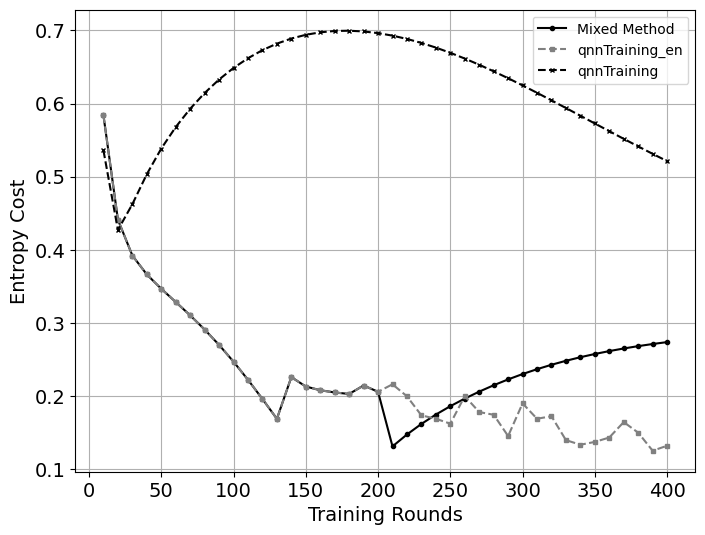

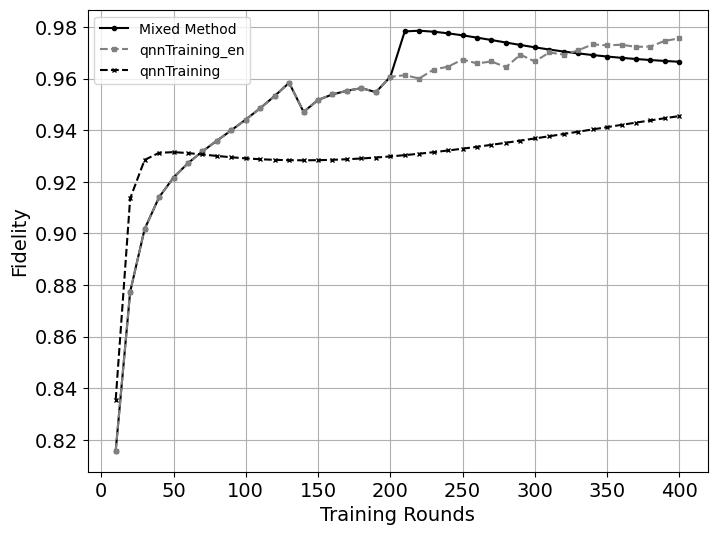

In [ ]:
#####Hybrid training ####
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import qutip as qt
import pandas as pd

# Generate random network data with flexible dimensions
data = randomNetwork([2, 3, 3, 2], 50)  # Generate 50 data samples

# Split data into training and testing
training_data, testing_data = train_test_split(data[2], test_size=10 / 50, random_state=42)

# Function to evaluate the QNN on provided data
def evaluate_qnn(qnnArch, trainedUnitaries, testingData):
    storedStates = feedforward(qnnArch, trainedUnitaries, testingData)
    outputStates = [states[-1] for states in storedStates]
    entropy_cost = entropy_costfunction(testingData, outputStates)
    return entropy_cost

# Initialize variables for performance metrics
mixed_entropy_cost_testing = []
mixed_fidelity_testing = []

unitaries_proposed_mixed = data[1]  # Initialize with initial unitaries

for i in range(40):
    print(f"Mixed Training iteration {i + 1}/40")

    # First 20 iterations use qnnTraining_en
    if i < 20:
        entropy_training_plot_mixed, unitaries_proposed_mixed = qnnTraining_en(
            data[0], unitaries_proposed_mixed, training_data, 1, 0.07, 10
        )
    # Next 20 iterations use qnnTraining
    else:
        entropy_training_plot_mixed, unitaries_proposed_mixed = qnnTraining(
            data[0], unitaries_proposed_mixed, training_data, 1, 0.07, 10
        )

    # Evaluate entropy cost on the test set
    entropy_testing_cost_mixed = evaluate_qnn(data[0], unitaries_proposed_mixed, testing_data)
    mixed_entropy_cost_testing.append(entropy_testing_cost_mixed)

    # Evaluate fidelity on the test set
    fidelity_testing_mixed = entropy_training_plot_mixed[1][-1]  # Fidelity metric
    mixed_fidelity_testing.append(fidelity_testing_mixed)

# Existing methods: Full qnnTraining_en and qnnTraining
en_only_entropy_cost_testing = []
en_only_fidelity_testing = []

training_only_entropy_cost_testing = []
training_only_fidelity_testing = []

unitaries_en_only = data[1]
unitaries_training_only = data[1]

for i in range(40):
    print(f"Single Method Training iteration {i + 1}/40")

    # Full qnnTraining_en
    entropy_training_plot_en, unitaries_en_only = qnnTraining_en(
        data[0], unitaries_en_only, training_data, 1, 0.07, 10
    )
    entropy_testing_cost_en = evaluate_qnn(data[0], unitaries_en_only, testing_data)
    en_only_entropy_cost_testing.append(entropy_testing_cost_en)
    fidelity_testing_en = entropy_training_plot_en[1][-1]
    en_only_fidelity_testing.append(fidelity_testing_en)

    # Full qnnTraining
    entropy_training_plot_training, unitaries_training_only = qnnTraining(
        data[0], unitaries_training_only, training_data, 1, 0.07, 10
    )
    entropy_testing_cost_training = evaluate_qnn(data[0], unitaries_training_only, testing_data)
    training_only_entropy_cost_testing.append(entropy_testing_cost_training)
    fidelity_testing_training = entropy_training_plot_training[1][-1]
    training_only_fidelity_testing.append(fidelity_testing_training)

# Save results to CSV
comparison_data = {
    "Mixed Method Entropy Cost": mixed_entropy_cost_testing,
    "qnnTraining_en Entropy Cost": en_only_entropy_cost_testing,
    "qnnTraining Entropy Cost": training_only_entropy_cost_testing,
    "Mixed Method Fidelity": mixed_fidelity_testing,
    "qnnTraining_en Fidelity": en_only_fidelity_testing,
    "qnnTraining Fidelity": training_only_fidelity_testing,
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv("Training_Method_Comparison.csv", index=False)

x_axis_values = [x * 10 for x in range(1, len(mixed_entropy_cost_testing) + 1)]

# Plot Entropy Cost Comparison
plt.figure(figsize=(8, 6))
plt.plot(x_axis_values, mixed_entropy_cost_testing, 'o-', color='black', label="Mixed Method", markersize=3)
plt.plot(x_axis_values, en_only_entropy_cost_testing, 's--', color='grey', label="qnnTraining_en", markersize=3)
plt.plot(x_axis_values, training_only_entropy_cost_testing, 'x--', color='black', label="qnnTraining", markersize=3)
plt.legend(fontsize=10)
plt.xlabel("Training Rounds", fontsize=14)
plt.ylabel("Entropy Cost", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.savefig("Mixed_Method_Entropy_Cost_Comparison.png", dpi=300)
plt.show()

# Plot Fidelity Comparison
plt.figure(figsize=(8, 6))
plt.plot(x_axis_values, mixed_fidelity_testing, 'o-', color='black', label="Mixed Method", markersize=3)
plt.plot(x_axis_values, en_only_fidelity_testing, 's--', color='grey', label="qnnTraining_en", markersize=3)
plt.plot(x_axis_values, training_only_fidelity_testing, 'x--', color='black', label="qnnTraining", markersize=3)
plt.legend(fontsize=10)
plt.xlabel("Training Rounds", fontsize=14)
plt.ylabel("Fidelity", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.savefig("Mixed_Method_Fidelity_Comparison.png", dpi=300)
plt.show()
